In [1]:
%%writefile load_imgs.py
import cv2
import numpy as np
def load_imgs(file,size=100):
    pic = cv2.imread(file)
    pic = cv2.resize(pic,(size,size))
    flg = file.split(r"\\")[-1] 
    if flg.startswith("cat"):
        label = 0
    else:
        label = 1
    
    return [pic,label]
def process_frame(f, size=100):
    return f, load_imgs(f[0],f[1])

Overwriting load_imgs.py


In [2]:
import time
start_time = time.time()
import numpy as np
import pandas as pd

from multiprocessing import Pool
from load_imgs import process_frame
from tqdm import tqdm
import cv2
import PIL
from os import listdir
import random

%matplotlib inline
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve

from sklearn.metrics import accuracy_score, classification_report




randomSeed = 36

Loading the data

In [3]:
picSize = 100
img_to_load = [(r"data\dogs-vs-cats\train\\"+i,picSize) for i in listdir(r"data\dogs-vs-cats\train\\")]
###########
random.shuffle(img_to_load)
img_to_load = img_to_load[:500]
############
p = Pool(processes=4)
func_input = [[i,picSize]  for i in img_to_load]
out = p.starmap(process_frame,func_input)


In [4]:
data = np.array([out[i][1][0] for i in range(len(out))])
target = [out[i][1][1] for i in range(len(out))]
out=None

Constructing our new pipeline

we will add all our transformations into a single pipeline so we can use gridSearch to find the best parameters
and best transformations

In [5]:
class recover(BaseEstimator, TransformerMixin):
    def __init__(self,size=100):
        self.picSize = size
    def fit(self,Data,y=None):
        return self
    def transform(self,Data,y=None):
        newData = []
        for img in Data:
            newData.append(img.reshape(self.picSize,self.picSize,3))
        return np.array(newData)

In [6]:
class erode_img(BaseEstimator, TransformerMixin):
    def __init__(self,matrix=None, iterations=0,size):
        self.matrix = matrix
        self.iterations=iterations
    def fit(self, Data, y=None):
        return self
    def transform(self,Data,y=None):
        newData = []
        if self.iterations > 0:
            for i in range(len(Data)):
                if Data[i].shape != (self.picSize,self.picSize):
                    newData.append(cv2.erode(Data[i].reshape(self.picSize,self.picSize,3),self.matrix,iterations=self.iterations))
                else:
                    newData.append(cv2.erode(Data[i],self.matrix,iterations=self.iterations))
            return newData
        return Data

SyntaxError: non-default argument follows default argument (<ipython-input-6-40a4a28d6797>, line 2)

In [7]:
class blur_img(BaseEstimator, TransformerMixin):
    def __init__(self,matrix=None, sigmaX=0):
        self.matrix = matrix
        self.sigmaX=sigmaX
    def fit(self, Data, y=None):
        return self
    def transform(self,Data,y=None):
        newData = []
        if self.sigmaX > 0:
            for i in range(len(Data)):
                if Data[i].shape != (self.picSize,self.picSize):
                    newData.append(cv2.GaussianBlur(Data[i].reshape(self.picSize,self.picSize,3),self.matrix,self.sigmaX))
                else:
                    newData.append(cv2.GaussianBlur(Data[i],self.matrix,self.sigmaX))
            return newData
        return Data

In [8]:
class dilate_img(BaseEstimator, TransformerMixin):
    def __init__(self,matrix=None, iterations=0):
        self.matrix = matrix
        self.iterations=iterations
    def fit(self, Data, y=None):
        return self
    def transform(self,Data, y=None):
        newData = []
        if self.iterations > 0:
            for i in range(len(Data)):
                if Data[i].shape != (self.picSize,self.picSize):
                    newData.append(cv2.dilate(Data[i].reshape(self.picSize,self.picSize,3),self.matrix,iterations=self.iterations))
                else:
                    newData.append(cv2.dilate(Data[i],self.matrix,iterations=self.iterations))
            return newData
        return Data

In [9]:
class grayScale(BaseEstimator, TransformerMixin):
    
    def fit(self, Data, y=None):
        return self
    def transform(self,Data, y=None):
        newData = []
        for i in range(len(Data)):
            newData.append(cv2.cvtColor(Data[i], cv2.COLOR_BGR2GRAY))
        return newData


In [10]:
class to_df(BaseEstimator, TransformerMixin):
    
    def fit(self, Data, y=None):
        return self

    def transform(self,Data, y=None):
        processed_data = np.array(Data)
        df = pd.DataFrame(np.array([a.flatten() for a in processed_data]))
        processed_data = None
        return df

In [11]:
class best_PCA(BaseEstimator, TransformerMixin):
    def __init__(self,threashold=0.95,random_state=None):
        self.threashold = threashold
        self.random_state = random_state
        self.dim = 0
        self.final_pca = PCA(random_state=self.random_state)
        self.is_fit = False

    def fit(self, Data, y=None):
        pca = PCA(random_state=self.random_state)
        pca.fit(Data)
        exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
        self.dim = len(exp_var_cumul[exp_var_cumul<self.threashold])
        self.final_pca = PCA(n_components=self.dim,random_state=self.random_state)
        self.final_pca.fit(Data)
        self.is_fit = True
        return self
    def transform(self,Data,y=None):
        if self.is_fit:
            newData = self.final_pca.transform(Data)
            return newData
        return Data

First i will show what will be happening behind the scenes when we are using HalvingGridSearchCV to find the best paramaters.

we will use this as data for our non-optimized baseline model

The steps are as follows:

1. Transforming the images by bluring, dilating, eroding and gray scaling the images
2. Transforming the 2d image matrices to a 1d arrays in a data frame
3. Reducing the images dimension with pca and finding the best dimension
4. Finally inputing the data into the XGBoost model

 Step 1: Transforming the data

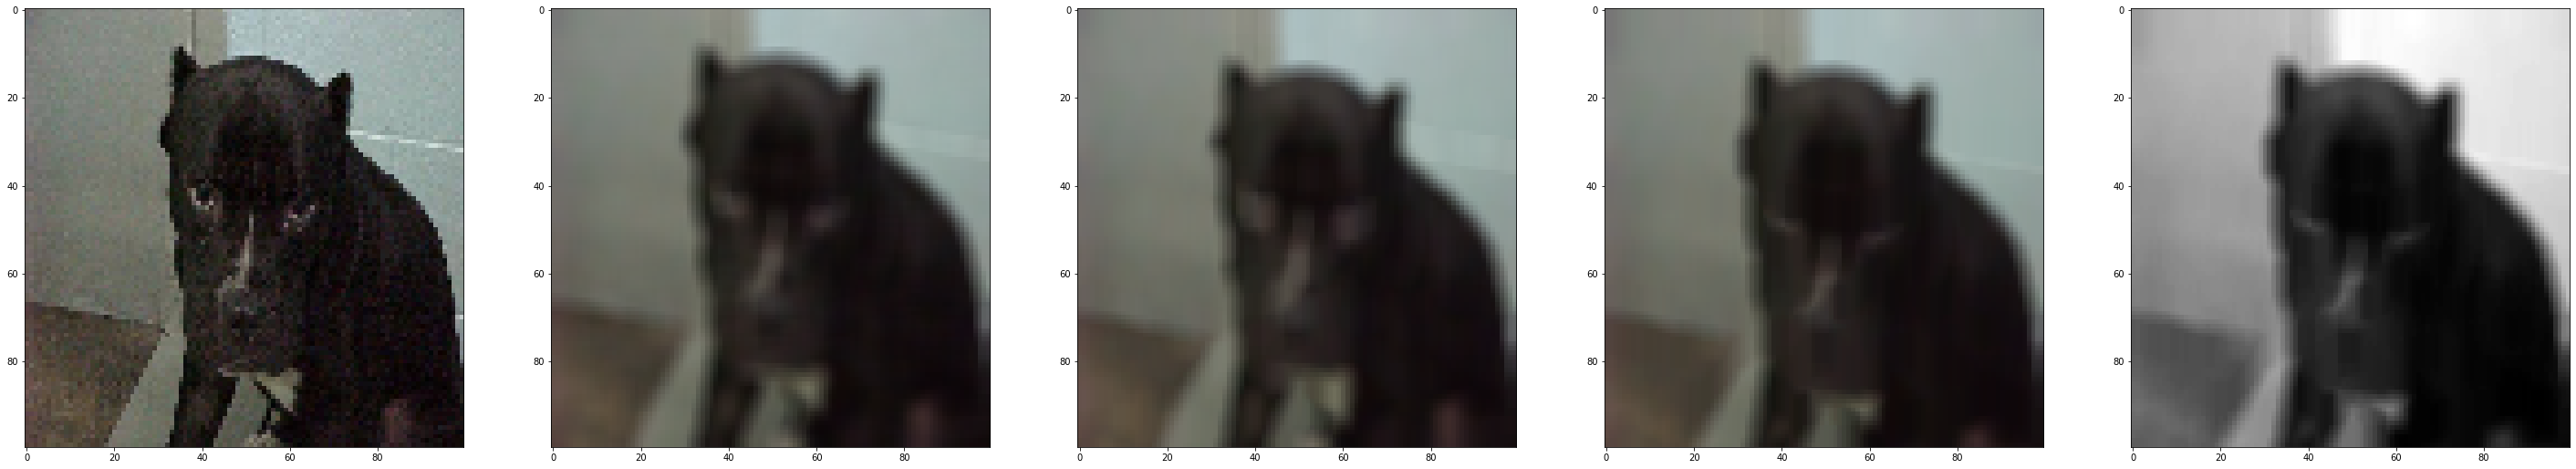

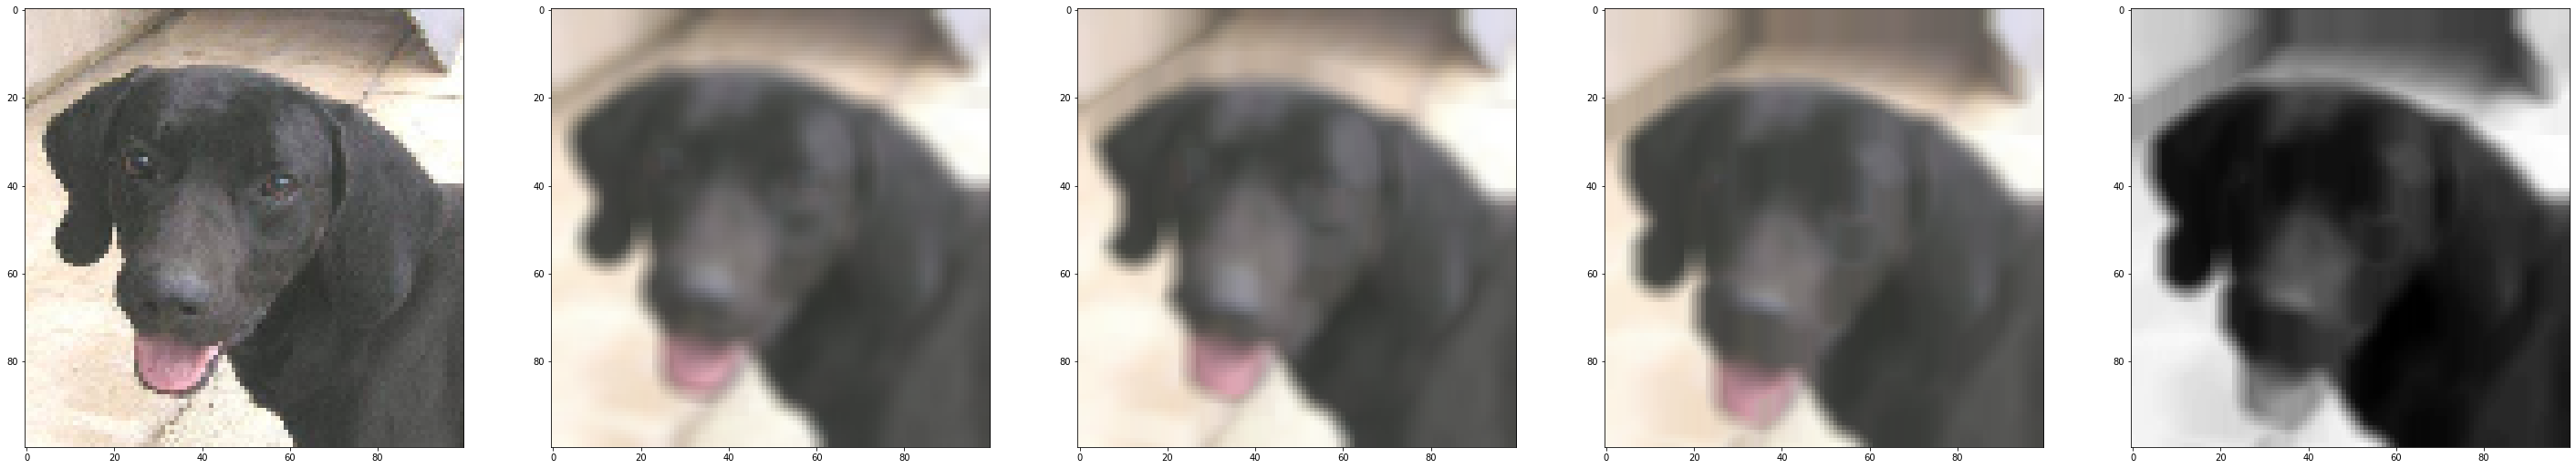

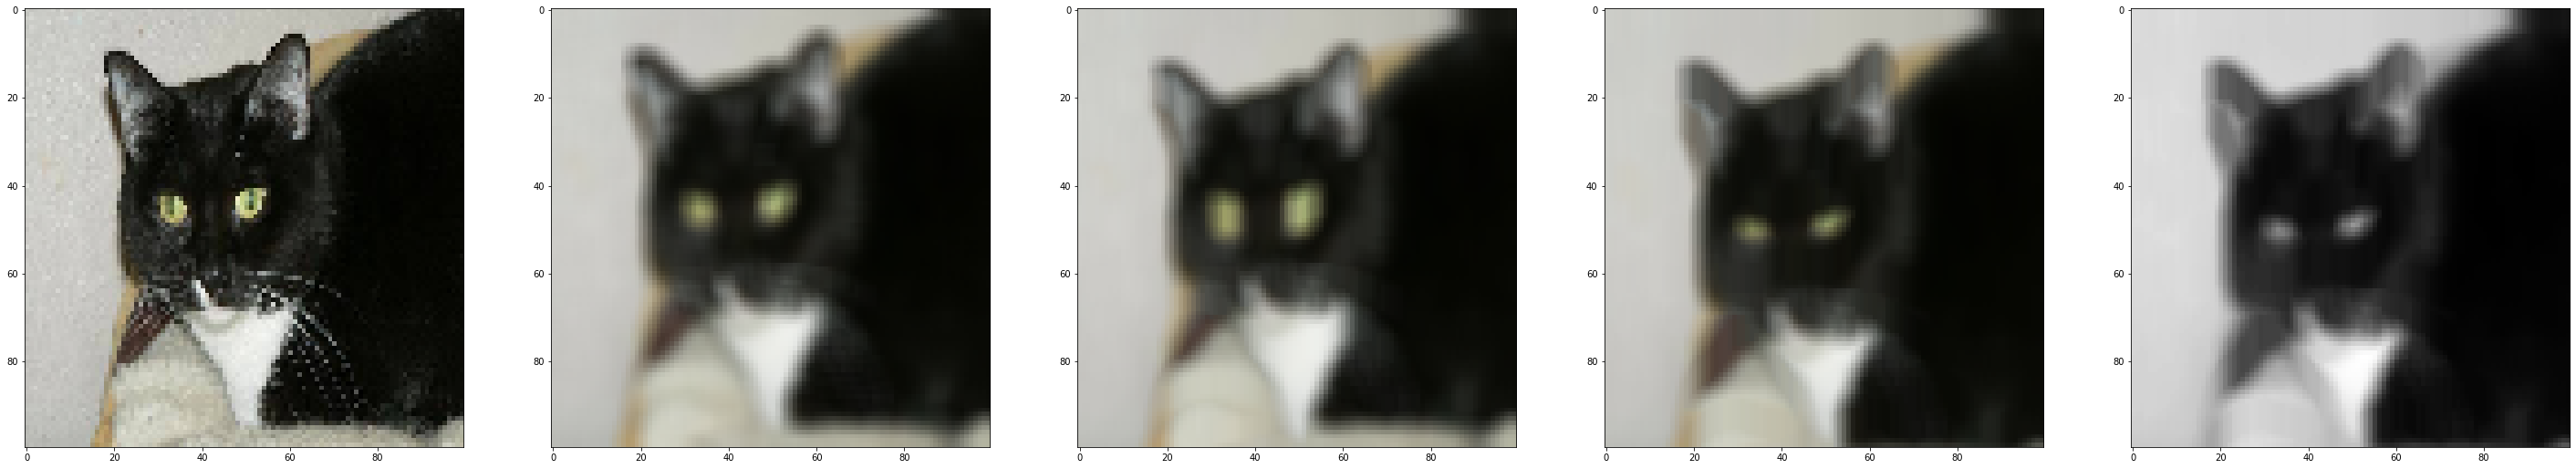

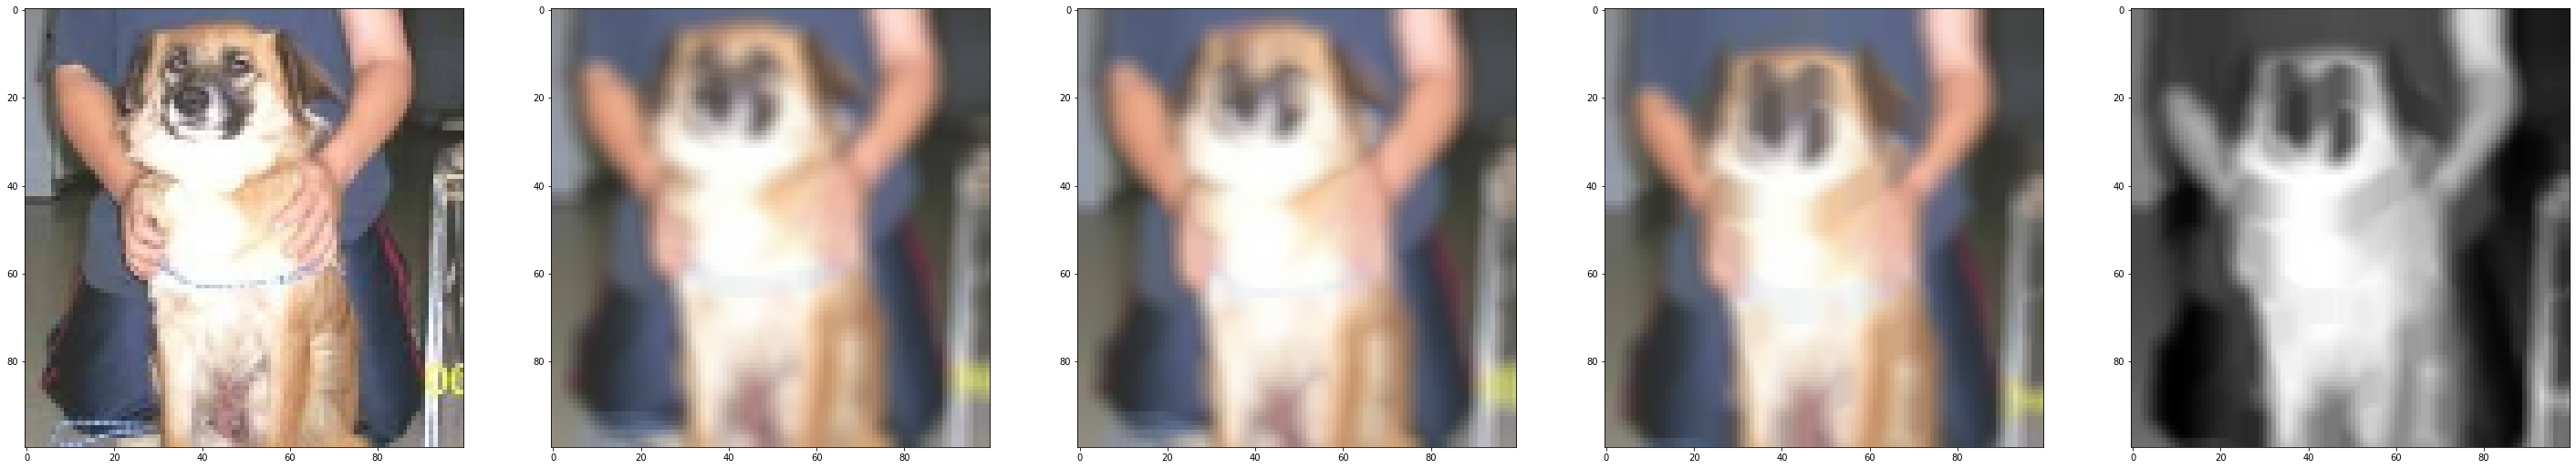

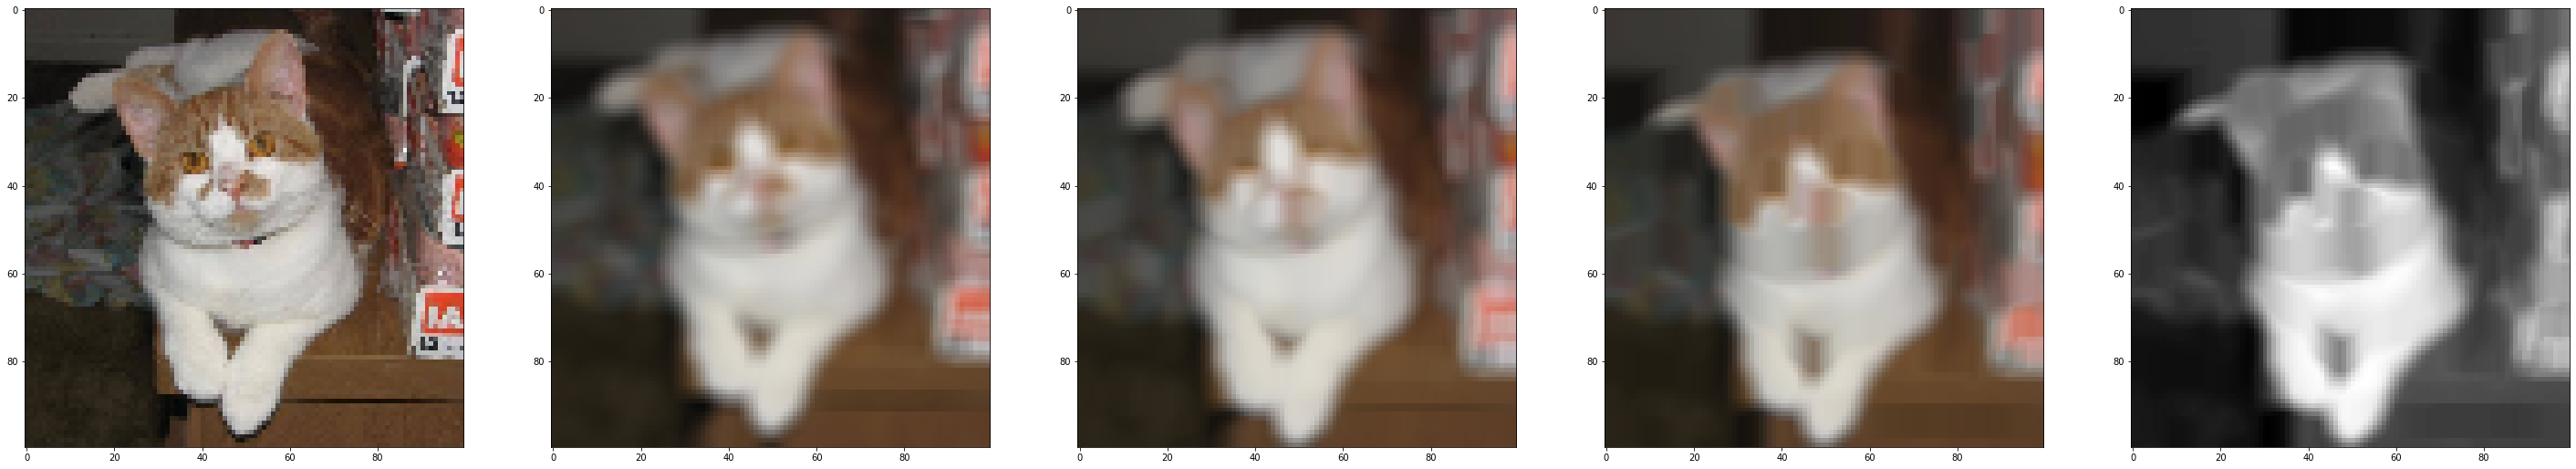

In [12]:
for i in range(5):
    blured = cv2.GaussianBlur(data[i],(5,5),9)
    dilated = cv2.dilate(blured,(1,1),iterations=3)
    eroded = cv2.erode(dilated,(3,3),iterations=6)
    grayScaled = cv2.cvtColor(eroded, cv2.COLOR_BGR2GRAY)

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
    fig.set_size_inches(50,10)
    ax1.imshow(cv2.cvtColor(data[i],cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(blured,cv2.COLOR_BGR2RGB))
    ax3.imshow(cv2.cvtColor(dilated,cv2.COLOR_BGR2RGB))
    ax4.imshow(cv2.cvtColor(eroded,cv2.COLOR_BGR2RGB))
    ax5.imshow(grayScaled,cmap="gray")

Step 2: Moving the data into a dataframe


In [13]:
img_preprocessing = Pipeline([
    ("blur",blur_img((5,5),9)),
    ("dilate",dilate_img((1,1),3)),
    ("erode",erode_img((3,3),6)),
    ("grayScale",grayScale())
])

processed_data = np.array(img_preprocessing.fit_transform(data))

In [14]:
df = pd.DataFrame(np.array([a.flatten() for a in processed_data]))

df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,117,118,120,123,125,128,130,131,131,132,...,18,16,16,16,16,16,16,16,15,15
1,219,218,218,216,215,215,215,213,213,213,...,86,86,85,84,82,79,77,75,73,72
2,204,204,203,203,202,202,204,204,204,204,...,28,23,22,24,35,46,59,73,82,82
3,140,140,135,125,113,103,95,91,92,93,...,148,178,181,186,166,157,135,139,138,137
4,54,54,55,55,55,56,56,56,56,56,...,69,68,68,69,69,69,69,68,68,67


Step 3: Reducing dimensions

We will use train and test data here temporeraly, this is not the final test/train data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=randomSeed)

In [16]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
68,201,201,200,198,197,195,192,190,187,185,...,146,146,146,146,145,144,144,143,142,141
78,207,207,179,144,114,111,100,122,153,179,...,117,140,173,204,225,239,247,250,250,251
339,73,71,76,81,85,83,86,89,91,93,...,114,110,106,107,106,107,108,103,103,103
132,77,77,74,69,66,61,57,54,51,50,...,29,29,29,28,29,27,22,17,15,13
325,73,73,62,61,61,65,66,66,65,64,...,188,191,194,195,195,193,192,192,191,191


In [17]:
pca = PCA()
pca.fit(X_train)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)


Feature variance ratio 

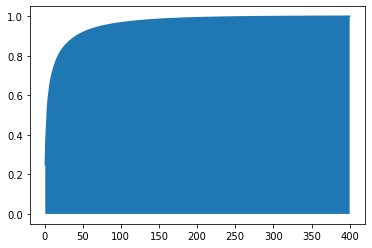

In [18]:
fig, ax = plt.subplots()
ax.plot(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul)
ax.fill_between(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul,0)

In [19]:
maxFeatures = len(exp_var_cumul[exp_var_cumul<0.95])

exp_var_cumul[maxFeatures], maxFeatures

(0.950262353694868, 75)

In [20]:
pca = PCA(n_components=maxFeatures,random_state=randomSeed)
X_train_new = pca.fit_transform(X_train)
X_test_new = pca.transform(X_test)

In [21]:
X_train_new.shape

(400, 75)

Preprocessed img before and after reducing dimensions

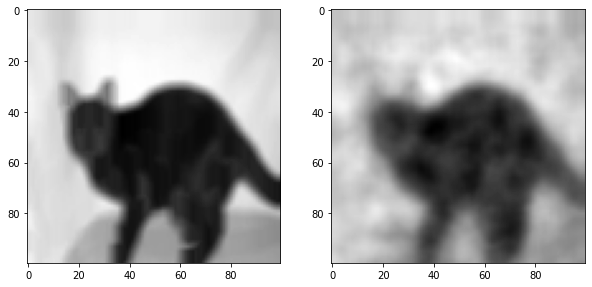

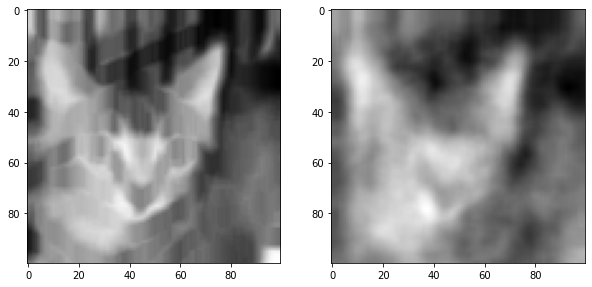

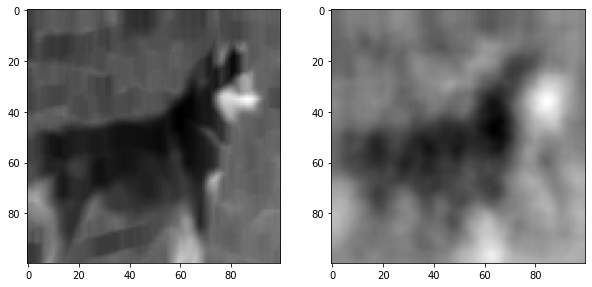

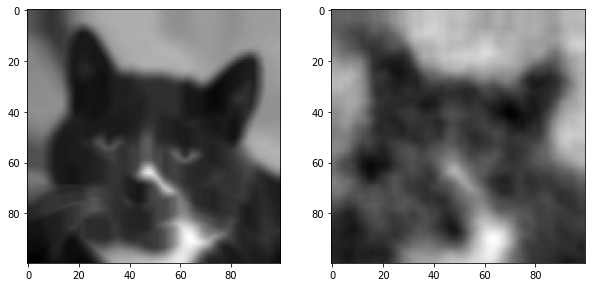

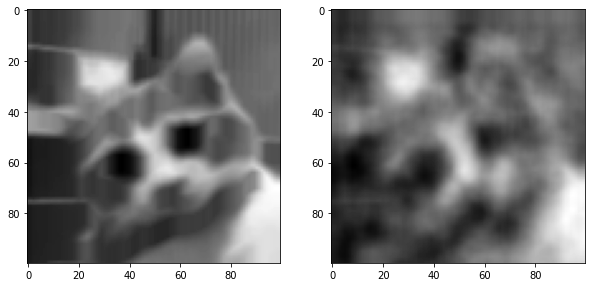

In [22]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10,5)
    img = X_train.iloc[i].to_numpy().reshape((picSize,picSize))
    ax1.imshow(img,cmap="gray")
    img = X_train_new[i]
    ax2.imshow(pca.inverse_transform(img).reshape((picSize,picSize)),cmap="gray")
    img = None

Step 4: creating our XGBoost model

This will act as a baseline model and we will try to improve it

In [23]:
def plot_model_results(model,X,y):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    cm = plot_confusion_matrix(model,X,y,display_labels=["cat","dog"],values_format="d",ax=ax1)
    fig.set_size_inches(20,10)
    num = cm.text_[0][0].get_text()
    txt = "True Negative"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[0][0].set_text(txt)
    
    num = cm.text_[1][0].get_text()
    txt = "False Negative"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[1][0].set_text(txt)

    num = cm.text_[0][1].get_text()
    txt = "False Positive"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[0][1].set_text(txt)

    num = cm.text_[1][1].get_text()
    txt = "True Positive"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[1][1].set_text(txt)
    
    falsePosRate, truePosRate, _ = roc_curve(y,np.random.choice([0,1],size=len(y_test)))
    plot_roc_curve(model,X,y,ax=ax2)
    ax2.plot(falsePosRate, truePosRate, linestyle='--')

In [24]:
baseline = xgb.XGBClassifier(seed=randomSeed)
baseline.fit(X_train_new,y_train)
baseline_prediction = baseline.predict(X_test_new)

C:\Users\zivmo\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[21:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
print("Accuracy:",accuracy_score(y_test,baseline_prediction))
print(classification_report(y_test,baseline_prediction))


Accuracy: 0.53
              precision    recall  f1-score   support

           0       0.49      0.59      0.53        46
           1       0.58      0.48      0.53        54

    accuracy                           0.53       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.54      0.53      0.53       100



100

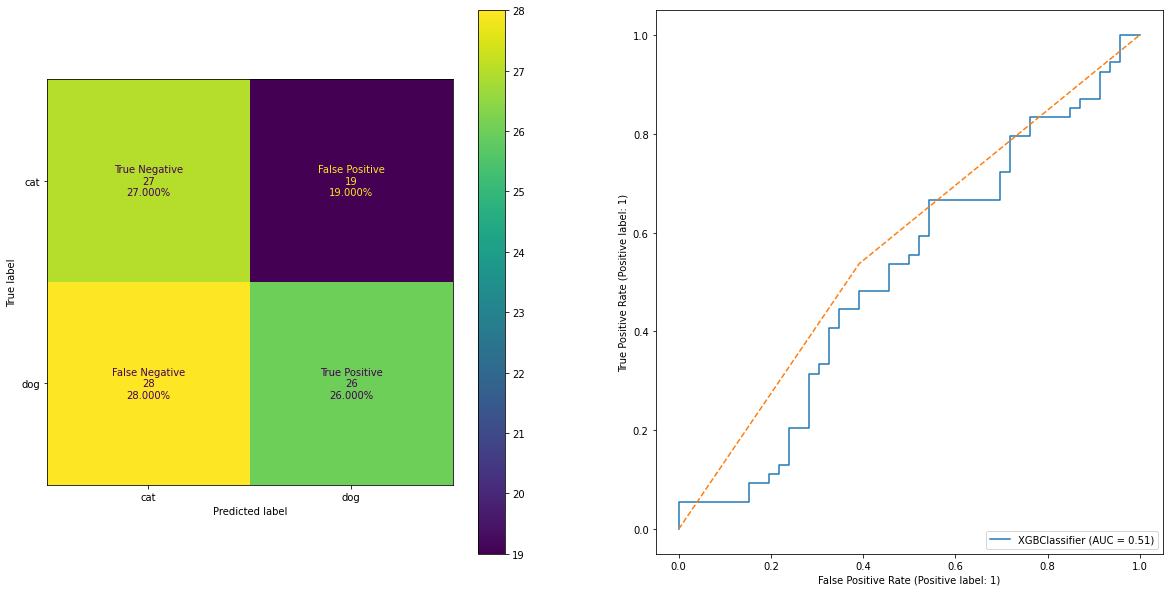

In [26]:
plot_model_results(baseline,X_test_new,y_test)

In [27]:
#train_scoreNum, test_scoreNum = validation_curve(AdaBoostClassifier(random_state=randomSeed), X = X_train_new, y = y_train, param_name = 'n_estimators', param_range = [200,600,800,1200], cv = 5, n_jobs=-1, verbose = 1)

In [28]:
#train_score_mean = np.mean(train_scoreNum,axis=1)
#train_score_std = np.std(train_scoreNum,axis=1)
#test_score_mean = np.mean(test_scoreNum,axis=1)
#test_score_std= np.std(test_scoreNum,axis=1)
#plt.semilogx([200,600,800,1200],train_score_mean)
#plt.fill_between([200,600,800,1200],train_score_mean-train_score_std,train_score_mean+train_score_std, alpha=0.2)
#plt.semilogx([200,600,800,1200],test_score_mean)
#plt.fill_between([200,600,800,1200],test_score_mean-test_score_std,test_score_mean+test_score_std, alpha=0.2)
#plt.show()

Now we will make our actual model, since we are going to change some of the parameters in our image transformations, we will reload the test and train set from the starting data 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(np.array([a.flatten() for a in processed_data]), target, test_size=0.2, random_state=randomSeed)

In [30]:
xgb_model = xgb.XGBClassifier(seed=randomSeed)

In [34]:
pipe = Pipeline([
    ("blur",blur_img()),
    ("dilate",dilate_img()),
    ("erode",erode_img()),
    ("grayScale",grayScale()),
    ("df",to_df()),
    ("pca",best_PCA(random_state=randomSeed)),
    ("model",xgb_model)
],verbose=True)
#("rec", recover(picSize)),

In [35]:
param_grid = {
    'blur__matrix':[(5,5)],
    'blur__sigmaX':[3],
    'dilate__matrix':[(5,5)],
    'dilate__iterations':[3],
    'erode__matrix':[(5,5)],
    'erode__iterations':[9],
    'pca__threashold':[0.95],
    'pca__random_state':[randomSeed],
    'model__n_estimators':[4000,5000,6000,7000,8000],
    'model__learning_rate':[0.001,0.01,0.05,0.5], 
    'model__random_state':[randomSeed]
}
#    'model__max_depth': [3, 4, 5],    'model__min_child_weight': [1, 5, 10], 

In [36]:
gridSearch_xgb = HalvingGridSearchCV(xgb_model, param_grid, cv=5,n_jobs=-1,verbose=3,random_state=randomSeed)

In [37]:
gridSearch_xgb.fit(X_train,y_train)
xgb_model = gridSearch_xgb.best_estimator_

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 44
max_resources_: 400
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 44
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 1
n_candidates: 7
n_resources: 132
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 2
n_candidates: 3
n_resources: 396
Fitting 5 folds for each of 3 candidates, totalling 15 fits
C:\Users\zivmo\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[21:25:13] WARNING: C:/Users/Administrator/wo

In [38]:
pred_xgb = xgb_model.predict(X_test)

In [39]:
print("Accuracy:",accuracy_score(y_test,pred_xgb))
print(classification_report(y_test,pred_xgb))

Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        46
           1       0.62      0.61      0.62        54

    accuracy                           0.59       100
   macro avg       0.59      0.59      0.59       100
weighted avg       0.59      0.59      0.59       100



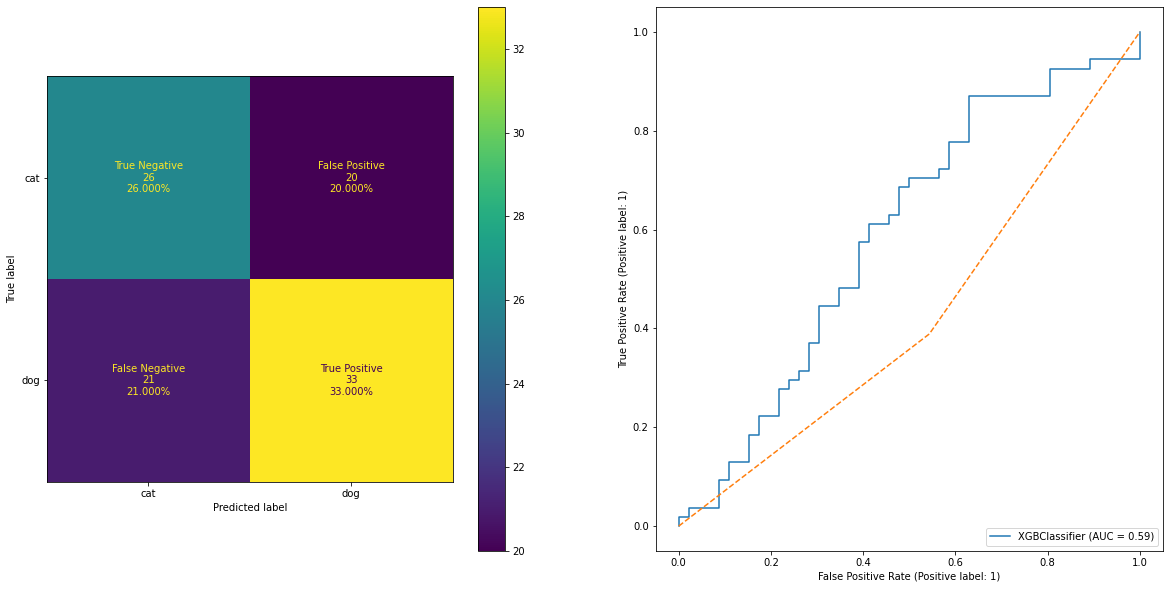

In [40]:
plot_model_results(xgb_model,X_test,y_test)

In [41]:
gridSearch_xgb.best_estimator_

XGBClassifier(base_score=0.5, blur__matrix=(5, 5), blur__sigmaX=3,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, dilate__iterations=3, dilate__matrix=(5, 5),
              erode__iterations=9, erode__matrix=(5, 5), gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, model__learning_rate=0.001,
              model__n_estimators=5000, model__random_state=36,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, pca__random_state=36, pca__threashold=0.95,
              random_state=36, ...)

In [42]:
from sklearn.ensemble import VotingClassifier

In [43]:
#voting = VotingClassifier(estimators=[('adaBoost',model),('randomForest',clf),('xgb',xgb_model)],n_jobs=-1,verbose=1,voting='soft')
#voting.fit(X_train_new,y_train)

In [44]:
#pred3 = voting.predict(X_test_new)

In [45]:
#print("Accuracy:",accuracy_score(y_test,pred3))
#print(classification_report(y_test,pred3))

In [46]:
#plot_confusion_matrix(voting,X_test_new,y_test,display_labels=["cat","dog"],values_format="d")


In [47]:
#plot_roc_curve(voting,X_test_new,y_test)

In [48]:
end_time = time.time()
e = end_time-start_time


In [49]:
print('{:02}:{:02}:{:02}'.format(e // 3600, (e % 3600 // 60), e % 60))

0.0:4.0:23.47454071044922
